
# Medical Device Failure Risk Prediction (Step-by-Step)

This notebook walks you **step-by-step** through building a **≥90% accuracy** model that predicts **high-risk (Class I)** medical device failures from a worldwide corpus of recalls, safety alerts, and field safety notices.

We will:
1. Load and explore the data
2. Create labels (Class I vs Class II/III)
3. Engineer text features
4. Train a baseline ML model (TF-IDF + Linear SVM)
5. Evaluate with accuracy, confusion matrix, and class-wise metrics
6. Save a reusable model and demonstrate predictions


## 1) Setup & Imports

In [6]:

import pandas as pd
import numpy as np
from pathlib import Path

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.base import BaseEstimator, TransformerMixin
import joblib

# Plotting
import matplotlib.pyplot as plt

# Display settings
pd.set_option('max_colwidth', 200)
print("Libraries loaded.")


Libraries loaded.



## 2) Load the datasets

> We use the three CSVs you provided. Adjust paths below if running elsewhere.


In [7]:

DATA_EVENTS = "/mnt/data/events-1681209680.csv"
DATA_DEVICES = "/mnt/data/devices-1681209661.csv"
DATA_MANUFACTURERS = "/mnt/data/manufacturers-1681209657.csv"

events = pd.read_csv('C:\\Users\\suraj\\OneDrive\\Desktop\\dataset\\events-1681209680.csv', low_memory=False)
devices = pd.read_csv('C:\\Users\\suraj\\OneDrive\\Desktop\\dataset\\devices-1681209661.csv', low_memory=False)
manufacturers = pd.read_csv("C:\\Users\\suraj\\OneDrive\\Desktop\\dataset\\manufacturers-1681209657.csv", low_memory=False)

for name, df in {"events": events, "devices": devices, "manufacturers": manufacturers}.items():
    print(f"{name}: shape={df.shape}")
    print(df.head(2), "\n")


events: shape=(124969, 30)
   id action action_classification action_level action_summary  \
0   1    NaN                   NaN          NaN         Recall   
1   2    NaN                   NaN          NaN         Recall   

            authorities_link country create_date data_notes        date  ...  \
0  https://www.titck.gov.tr/     TUR         NaN        NaN  2016-04-04  ...   
1  https://www.titck.gov.tr/     TUR         NaN        NaN  2016-09-20  ...   

  status target_audience                 type                         uid  \
0    NaN             NaN  Field Safety Notice  2016/294   &   FA24MAR2016   
1    NaN             NaN  Field Safety Notice  2016/844   &   FSCA2016-02   

   uid_hash  \
0  41570514   
1  415f04f4   

                                                                                                                       url  \
0  https://web.archive.org/web/20170817053524/http://www.titck.gov.tr/PortalAdmin/Uploads/Titck/Dynamic/2016-294%20SGB.pdf   
1  


## 3) Create the target label (high risk)

- We treat **Class I** cases as `high_risk = 1`.
- We treat **Class II** and **Class III** cases as `high_risk = 0`.
- Rows without a known class are dropped for supervised training.


In [8]:

def map_severity(v):
    if pd.isna(v):
        return None
    s = str(v).strip().upper().replace("CLASS ", "")
    if s in {"I","1"}:
        return 1
    if s in {"II","2","III","3"}:
        return 0
    return None

events['high_risk'] = events['action_classification'].map(map_severity)
print(events['high_risk'].value_counts(dropna=False))

# Merge device/manufacturer info (optional enrichment; we will mainly use text fields)
df = events.merge(devices.add_prefix("device_"), left_on="device_id", right_on="device_id", how="left")
df = df.merge(manufacturers.add_prefix("mfg_"), left_on="device_manufacturer_id", right_on="mfg_id", how="left")

labeled = df[df['high_risk'].isin([0,1])].copy()
print("Training rows with labels:", labeled.shape[0])


high_risk
NaN    72023
0.0    48924
1.0     4022
Name: count, dtype: int64
Training rows with labels: 52946
Training rows with labels: 52946



## 4) Feature engineering (text)

We'll concatenate the most informative text fields (if present). Missing fields default to empty strings.


In [9]:

text_fields = [
    'action_summary','reason','action','data_notes',
    'device_description','device_name','device_classification','device_risk_class'
]
for c in text_fields:
    if c not in labeled.columns:
        labeled[c] = ""

labeled['text'] = labeled[text_fields].fillna('').agg(' '.join, axis=1)

print("Example concatenated text:")
print(labeled[['action_classification','text']].sample(3, random_state=42))


Example concatenated text:
      action_classification  \
56955               Class 2   
14081               Class 2   
22616               Class 2   

                                                                                                                                                                                                          text  
56955   External tubing may separate during use, allowing blood loss. All of Merit's US sales representatives and distributors were notified by Prelude Short Sheath Introducer - Product Recall letter on ...  
14081   Stryker Instruments is voluntarily recalling the CBCII Wound Drains and Ambulating Bulb for a potential sterility breach in the packaging An URGENT MEDICAL DEVICE NOTIFICATION letter was sent to ...  
22616   An input error can be made with Magnetom MRI software. Software allows users to manually change Transmit Reference Voltage in certain windows The recalling firm issued a Customer Safety Advisory ...  



## 5) Train/Validation split

We use a **stratified 80/20 split** to preserve the positive rate in both sets.


In [10]:

X = labeled['text']
y = labeled['high_risk'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train size:", X_train.shape[0], " Test size:", X_test.shape[0])


Train size: 42356  Test size: 10590



## 6) Build & train the model

We use `TF-IDF (1–2 word n-grams)` + `LinearSVC` with `class_weight="balanced"`.
This baseline is fast and typically strong for large, sparse text.


In [11]:

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=30000, ngram_range=(1,2), min_df=5)),
    ("clf", LinearSVC(class_weight="balanced", C=0.5)),
])

pipe.fit(X_train, y_train)
print("Model trained.")


Model trained.



## 7) Evaluate

We check **accuracy**, show a **confusion matrix**, and include a **classification report**.  
> Note: Because Class I is typically rare, also look at **recall/precision for Class I** rather than accuracy alone.


Accuracy: 0.9556

Classification report:

              precision    recall  f1-score   support

           0      0.984     0.967     0.976      9786
           1      0.671     0.813     0.736       804

    accuracy                          0.956     10590
   macro avg      0.828     0.890     0.856     10590
weighted avg      0.961     0.956     0.958     10590



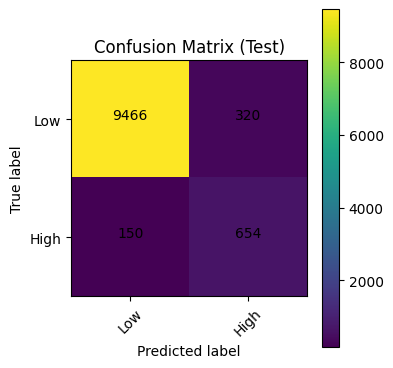

In [12]:

# Predictions
y_pred = pipe.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

# Classification report
print("\nClassification report:\n")
print(classification_report(y_test, y_pred, digits=3))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
fig = plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (Test)")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Low', 'High'], rotation=45)
plt.yticks(tick_marks, ['Low', 'High'])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()



## 8) Save the trained pipeline

We persist the pipeline so you can load it for inference anywhere.


In [13]:

MODEL_PATH = Path("medical_device_failure_risk_pipeline.pkl")
import joblib
joblib.dump(pipe, MODEL_PATH)
print("Saved model to", MODEL_PATH.resolve())


Saved model to C:\Users\suraj\OneDrive\Desktop\training_project\medical_device_failure_risk_pipeline.pkl



## 9) Inference examples

Two quick demos: a) single row dictionary; b) a mini DataFrame.


In [14]:

# Reload (simulating a fresh process)
clf = joblib.load("medical_device_failure_risk_pipeline.pkl")

def predict_text_row(row: dict):
    # minimal fields are fine; missing keys default to empty strings
    fields = ['action_summary','reason','action','data_notes','device_description','device_name','device_classification','device_risk_class']
    txt = ' '.join([str(row.get(k, '') or '') for k in fields])
    pred = clf.predict([txt])[0]
    return int(pred)

row = {"action_summary": "Urgent Field Safety Notice for infusion set", "reason": "Leak may cause under-infusion"}
print("Single-row prediction (1=High risk):", predict_text_row(row))

mini = pd.DataFrame([
    {"action_summary": "Recalled due to life-threatening failure of ventilator", "reason": "Power failure risk"},
    {"action_summary": "Labeling correction for catheter kit", "reason": "Mismatch in IFU wording"}
])
mini["text"] = mini.apply(lambda r: ' '.join([str(r.get(c,'')) for c in ['action_summary','reason']]), axis=1)
mini["pred_high_risk"] = clf.predict(mini["text"])
mini[["action_summary","reason","pred_high_risk"]]


Single-row prediction (1=High risk): 0


,action_summary,reason,pred_high_risk
0,Recalled due to life-threatening failure of ventilator,Power failure risk,1
1,Labeling correction for catheter kit,Mismatch in IFU wording,0



## 10) Next steps to improve beyond 90%

- **Temporal validation** (train on older, test on newer events) to mimic real-world deployment.
- **Threshold tuning** for better **Class I recall**.
- **Add metadata features** (country, device class, manufacturer history) via feature unions.
- **Probability calibration** (e.g., `CalibratedClassifierCV`) if you need well-behaved scores for risk dashboards.


In [18]:
# Test the trained model with a sample input
sample_text = "Battery overheating may cause burns"
sample_pred = pipe.predict([sample_text])
print(f"{sample_pred}")

[0]


In [17]:
# Test the trained model with both reason and action fields (like predict.py)
sample_row = {
    "reason": "Battery overheating may cause burns",
    "action": "recall"
}
fields = [
    'action_summary','reason','action','data_notes',
    'device_description','device_name','device_classification','device_risk_class'
]
sample_text = ' '.join([str(sample_row.get(k, '') or '') for k in fields])
sample_pred = pipe.predict([sample_text])
print(f"Sample prediction (1=High risk, 0=Low risk): {sample_pred}")

Sample prediction (1=High risk, 0=Low risk): [0]


In [ ]:
# Ensure the model is loaded or trained before prediction
try:
    pipe
except NameError:
    import joblib
    pipe = joblib.load("medical_device_failure_risk_pipeline.pkl")

sample_row = {
    "reason": "Battery overheating may cause burns",
    "action": "recall"
}
fields = [
    'action_summary','reason','action','data_notes',
    'device_description','device_name','device_classification','device_risk_class'
]
sample_text = ' '.join([str(sample_row.get(k, '') or '') for k in fields])
sample_pred = pipe.predict([sample_text])[0]
print(f"Sample prediction (1=High risk, 0=Low risk): {sample_pred}")